In [1]:
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import yaml
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

### Defining constants

We need to define the size of the window, in terms of days, for which we want to predict the optimal policy set. In our structure, when a set of policy is decided it must be active for at least one week before changing it, for stability reasons. This is reasonable also looking at the real world, but you can change this parameter from the code below. We also define the other parameters.
For stability each policy can vary between -1 and +1 in one week.



In [3]:
WINDOW_SIZE = 28
CHANGE_EVERY = 7

assert WINDOW_SIZE % CHANGE_EVERY == 0

TARGET_COUNTRY = 'CHE'

STARTING_DATE = '2021-01-31'

### Training the reproduction rate neural network for the target country

Now we need to decide on which country we are going to optimize the policy set. We train the reproduction rate network accordingly.

In [4]:
data_swissre = pd.read_csv('data/final_data.csv', parse_dates=['date']).set_index('date')

Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
data_swissre_original = data_swissre.copy() 

In [6]:
data_swissre = data_swissre[data_swissre.index >= '2020-04-01']
data_swissre = data_swissre[data_swissre.index <= STARTING_DATE]

In [7]:
# Selecting the features
with open('config/reinforcement_learning_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['rep_rate'] +\
            swissre_features['vaccines']['rep_rate'] +\
            swissre_features['policies'] +\
            swissre_features['outcome']['rep_rate']

outcome = 'epiforecasts_effective_reproduction_number_median'

df = data_swissre[columns_to_use].copy()

# Taking the data starting from the 1st of april.
df = df[df.index >= '2020-04-01'].sort_index()

In [9]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

In [10]:
df = filter_valid_countries(df, 0.9)

In [11]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 168


In [12]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])
df['r_estim'] = df[outcome]

In [13]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 152


In [14]:
# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['rep_rate'] +\
            swissre_features['vaccines']['rep_rate'] +\
            swissre_features['policies']

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == TARGET_COUNTRY][col].isnull().all()]
#final_train_cols = [col for col in final_train_cols if not df[col].std() == 0]

final_train_cols = list(set(final_train_cols) - set(['fiscal_measures', 'emergency_investment_in_health_care', 'investment_in_vaccines']))

In [15]:
context = Context()
pipeline = Pipeline(df, final_train_cols, 'r_estim', TARGET_COUNTRY, WINDOW_SIZE, context)
pipeline.fit_pipeline(save_model=False)

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.6 K 
1 | linear_1 | Linear | 2.4 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

.........................................

The mean average error was 0.023670580053688325


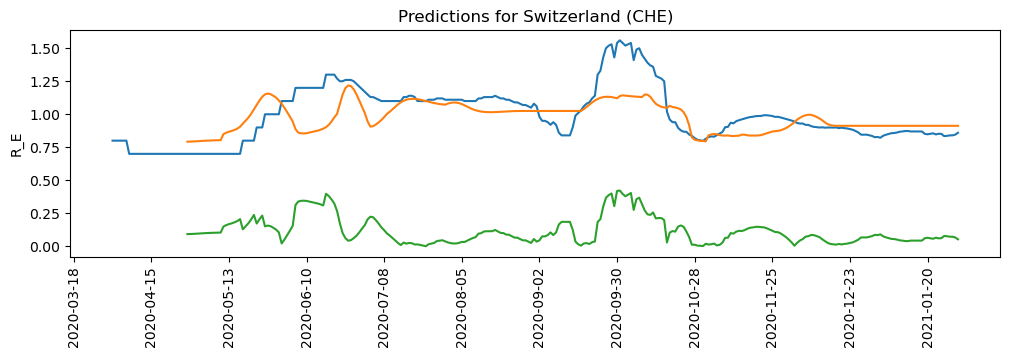

In [16]:
predictions = pipeline.predict()

plot = Plot(df, 'r_estim', TARGET_COUNTRY, 'Switzerland', save_path='./plots/') 
plot.plot_results(predictions, show = True)

### Training the economic neural network for the target country

In [17]:
data_swissre_economic = pd.read_csv('./data/economic_weighted.csv', parse_dates=['date']).set_index('date')

iso_codes_economic = ['AUT','BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR', 'CHE', 'NOR']

data_swissre_economic = data_swissre_economic[data_swissre_economic['iso_code'].isin(iso_codes_economic)]

Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.


In [18]:
data_swissre_economic_original = data_swissre_economic.copy()

In [19]:
columns_to_use_economic = swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['unemp_rate'] +\
            swissre_features['policies'] +\
            swissre_features['outcome']['unemp_rate']+\
            swissre_features['economic_config']


rep_rate = 'epiforecasts_effective_reproduction_number_median'

In [20]:
df_economic = data_swissre_economic[columns_to_use_economic].copy()
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df_economic = df_economic[df_economic.index >= '2020-04-01'].sort_index() 
df_economic = df_economic[df_economic.index <= STARTING_DATE].sort_index()

In [21]:
# Filtering for valid countries
df_economic = filter_valid_countries(df_economic, 0.9)

In [22]:
print(f"Number of countries: {len(df_economic.iso_code.unique())}")

Number of countries: 29


In [23]:
# Putting NaN where the estimated reproduction number is larger than 4
df_economic[rep_rate] = np.where(df_economic[rep_rate] >= 4, np.nan, df_economic[rep_rate])

In [24]:
# Shifting the reproduction rate by 11 days for each country
df_economic['date_index'] = df_economic.index
df_economic = df_economic.sort_values(by = ['iso_code', 'date_index'])
df_economic['shifted_r_estim'] = df_economic[rep_rate]

In [25]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df_economic[df_economic['cases'] > 2000]['iso_code'].unique())
df_economic = df_economic[df_economic['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df_economic.iso_code.unique())}")

Number of countries: 29


In [26]:
# Final training colums
train_cols_economic= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['unemp_rate'] +\
            swissre_features['policies'] + ['shifted_r_estim'] # Check shifted r estim

final_train_cols_economic = [col for col in train_cols_economic if not df_economic[df_economic['iso_code'] == TARGET_COUNTRY][col].isnull().all()]
final_train_cols_economic = [col for col in final_train_cols_economic if not df_economic[df_economic['iso_code'] != TARGET_COUNTRY][col].std() == 0]
final_train_cols_economic = list(set(final_train_cols_economic) - set(['fiscal_measures', 'emergency_investment_in_health_care', 'investment_in_vaccines', 'shifted_r_estim'])) #problematic columns

In [27]:
context_economic = Context()

Global seed set to 42


In [28]:
pipeline_economic = Pipeline(df_economic, final_train_cols_economic, 'unemployment_rate_idx', TARGET_COUNTRY, WINDOW_SIZE, context_economic, 'weight') #shifted_r_estim
pipeline_economic.fit_pipeline(save_model=False)

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.6 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

...........................

<AxesSubplot:xlabel='index'>

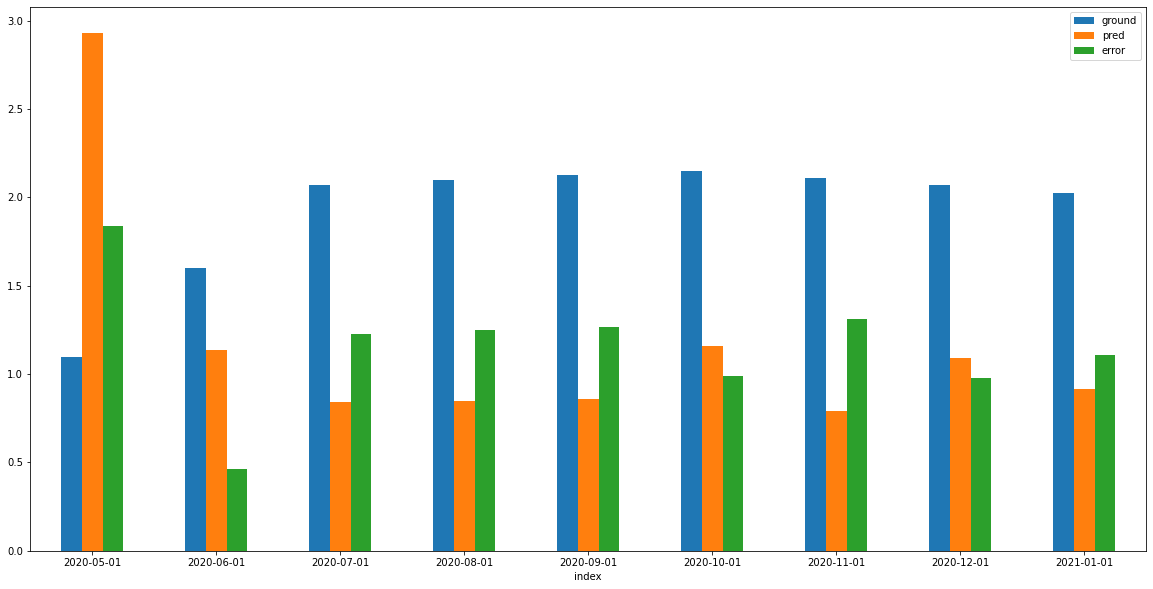

In [29]:
predictions_economic = pipeline_economic.predict()

test_indices = df_economic['iso_code'] == TARGET_COUNTRY
index = df_economic.loc[test_indices].index
ground = df_economic.loc[test_indices]['unemployment_rate_idx']
error_curve = np.abs(ground - predictions_economic)

df2 = pd.DataFrame({'index': index, 'ground': ground, 'pred': predictions_economic, 'error': error_curve}).sort_values(by = 'index')
df2 = df2[(df2['index'] >= '2020-05-01') & (df2['index'].dt.day == 1)]

df2['index'] = df2['index'].dt.date


df2.plot.bar(x = 'index', y = ['ground', 'pred', 'error'], rot = 0, figsize=(20, 10))

### Defining the initial state of the RL agent

In [30]:
# model = pipeline.get_model()
# print(pipeline.get_data()[1][1].shape)
# print(pipeline.get_data()[1][0].shape)

In [31]:
variable_names = pipeline.get_cols()[1]
variable_names_economic = pipeline_economic.get_cols()[1]
# variable_names

In [32]:
variable_names

['cancel_public_events',
 'close_public_transport',
 'contact_tracing',
 'international_travel_controls',
 'public_information_campaigns',
 'restrictions_on_gatherings',
 'restrictions_on_internal_movement',
 'school_closing',
 'stay_at_home_requirements',
 'testing_policy',
 'workplace_closing']

In [33]:
variable_names_economic
# TODO: see shifted_r_estim? Instead of doing the repeat in predict_from_state, you have to predict it every day, doing a roll day by day

['cancel_public_events',
 'close_public_transport',
 'contact_tracing',
 'international_travel_controls',
 'public_information_campaigns',
 'restrictions_on_gatherings',
 'restrictions_on_internal_movement',
 'school_closing',
 'stay_at_home_requirements',
 'testing_policy',
 'workplace_closing']

In [34]:
constant_features = pipeline.get_data()[1][0][-1].numpy()
constant_names = pipeline.get_cols()[0]

constant_features_economic = pipeline_economic.get_data()[1][0][-1].numpy()
constant_names_economic = pipeline_economic.get_cols()[0]


In [35]:
variable_beginning_features = pipeline.get_data()[1][1][-1].numpy()[::CHANGE_EVERY]

initial_state = []
for day in variable_beginning_features:
    initial_state.append(pipeline.get_denorm_data(variable_names, [day]))
initial_state = np.array(initial_state).flatten()

In [36]:
initial_state

array([2., 0., 2., 3., 2., 4., 0., 2., 1., 2., 2., 2., 0., 2., 3., 2., 4.,
       0., 2., 1., 2., 2., 2., 0., 2., 3., 2., 4., 0., 2., 1., 2., 2., 2.,
       0., 2., 3., 2., 4., 0., 2., 1., 2., 2.])

In [37]:
def predict_from_state(state):
    """ Given a state, it makes a prediction """
    network_input = state.reshape(int(WINDOW_SIZE / CHANGE_EVERY), len(variable_names))
    network_input = np.repeat(network_input, CHANGE_EVERY, axis=0) 
    prediction = pipeline.single_prediction(variable_names, constant_names, network_input, [constant_features], norm_var=True).numpy()[0][0]
    prediction_economic = pipeline_economic.single_prediction(variable_names_economic, constant_names_economic, network_input, [constant_features_economic], norm_var=True).numpy()[0][0]
    return prediction, prediction_economic

In [38]:
predict_from_state(np.zeros(44))

(0.980823224533915, 0.8871239689457493)

## Reinforcement learning

### Step 1: Importing the DDPG agent

In [39]:
from classes.ddpg.agent import DDPGAgent
from classes.ddpg.plot_results import Results

### Step 2: Traning

In [40]:
state_space = initial_state.shape[0]
action_space = len(variable_names)
# Defining the range of variation for each policy
variation_policy_level = [3, 3, 3, 5, 3, 5, 3, 4, 4, 4, 4] #[3, 3, 3, 5, 3, 5, 3, 4, 4, 4, 6, 4]
MAX_EPISODES = 2500
MAX_STEPS = int(WINDOW_SIZE / CHANGE_EVERY)





def run_rl(random=False, warmup=128):
    agent = DDPGAgent(state_space, action_space)
    results = Results()
    rewards = []
    best_reward = 0
    best_states = []
    
    for episode in range(MAX_EPISODES):
        episode_reward = 0.
        s_t = initial_state
        agent.reset()
        # Initial prediction
        last_prediction, last_prediction_economic = predict_from_state(s_t)
        states = []

        for step in range(MAX_STEPS):
            if random:
                action = agent.random_action()
            else:
                action = agent.select_action(s_t)            
            new_policies = s_t[-11:] + action # SOLVE PROBLEM -1, 1


            # Creating the new state
            next_state = np.roll(s_t, -11)
            next_state[-11:] = new_policies

            # Computing the reward
            prediction, prediction_economic = predict_from_state(next_state)
            r_t_1 = 100 * (last_prediction - prediction) / last_prediction
            r_t_2 = 100 * (last_prediction_economic - prediction_economic) / last_prediction_economic
            #r_t_1 = 1/prediction
            #r_t_2 = 1/prediction_economic
            #print(r_t_1, "\t", r_t_2)
            #r_t = 2*r_t_1*r_t_2/(r_t_1+r_t_2)
            #r_t = r_t_1
            
            r_t = (r_t_1 + r_t_2) / 2
            
            done = step == (int(WINDOW_SIZE / CHANGE_EVERY) - 1)
            if not random:
                # agent observe and update policy
                agent.memory.push(s_t, action, r_t, next_state, done)

                if len(agent.memory) > warmup:
                    agent.update()

            episode_reward += r_t
            s_t = next_state
            #last_prediction, last_prediction_economic = prediction, prediction_economic

            states.append(s_t)

            # End of an episode
            if done:  
                rewards.append(episode_reward)
                break
     
    
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_states = states

        if episode % 10 == 0:
            results['R/Economy trade-off'] = np.array(rewards)
            results.plot(10)
    return best_states, best_reward, rewards

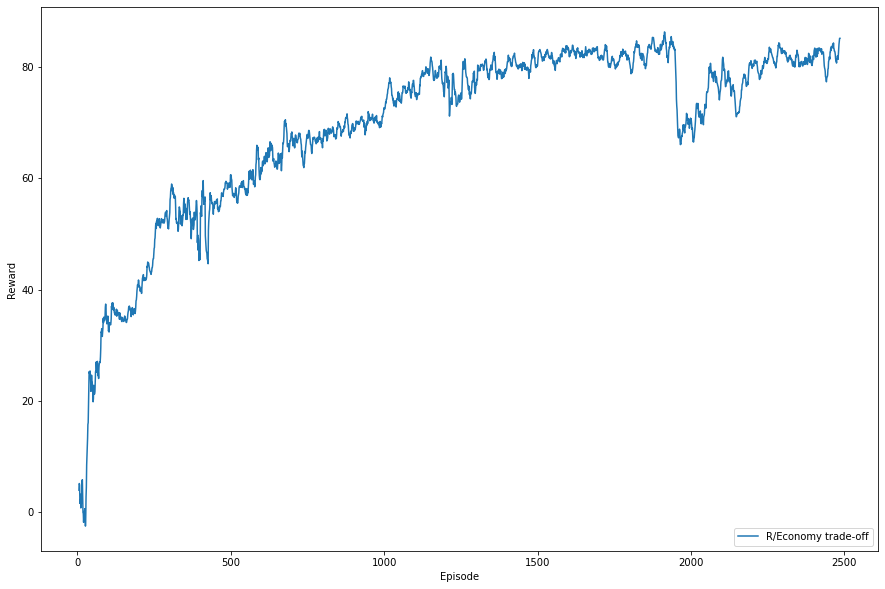

In [41]:
best_states, best_reward, rewards = run_rl()

In [42]:
print(f"Best reward - RL {best_reward}")

Best reward - RL 91.05684010777443


In [43]:
initial_re, initial_unemp = predict_from_state(initial_state)
final_re, final_unemp = predict_from_state(best_states[3])

print(final_re, final_unemp)

0.6763293362494806 0.6608399869170698


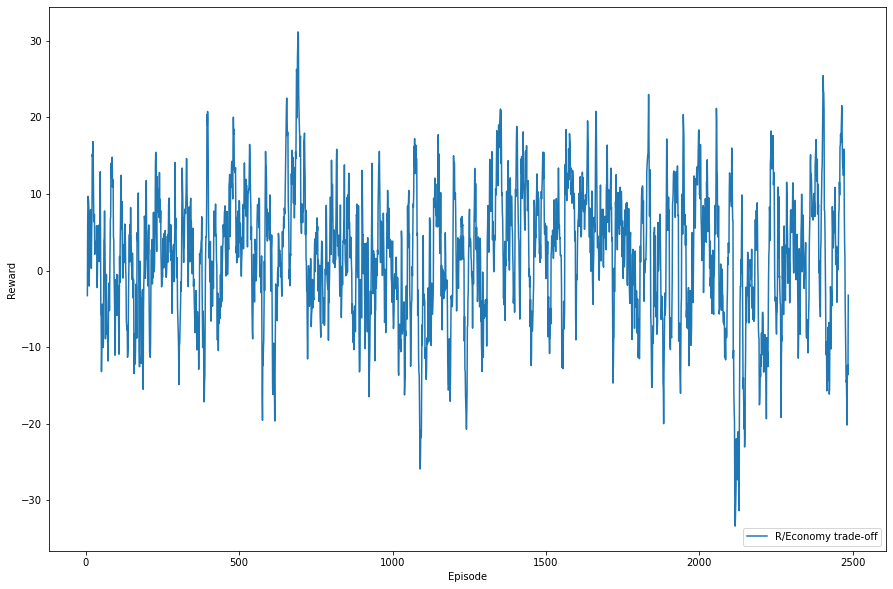

In [44]:
best_states_random, best_reward_random, rewards =run_rl(random=True)

In [45]:
print(f"Best reward - random {best_reward_random}")

Best reward - random 86.10515430728762


### Step 3: Visualizing how the reproduction rate evolved

- Setting 1: continuous policies
- Setting 2: rounded non-negative policies
- Setting 3: bounded policies

In [46]:
data_swissre_original = data_swissre_original[data_swissre_original['iso_code'] == 'CHE']
reproduction_rate_true = data_swissre_original[(data_swissre_original.index == '2021-04-12') | (data_swissre_original.index == '2021-04-19') | (data_swissre_original.index == '2021-04-26') | (data_swissre_original.index == '2021-05-03') | (data_swissre_original.index == '2021-05-09')]['epiforecasts_effective_reproduction_number_median'].values
reproduction_rate_true



array([1.00034348, 0.9284954 , 0.88596892, 0.88728507, 0.90499585])

In [47]:
data_swissre_economic_original = data_swissre_economic_original[data_swissre_economic_original['iso_code'] == 'CHE']
economic_true = data_swissre_economic_original[(data_swissre_economic_original.index == '2021-04-12') | (data_swissre_economic_original.index == '2021-04-19') | (data_swissre_economic_original.index == '2021-04-26') | (data_swissre_economic_original.index == '2021-05-03') | (data_swissre_economic_original.index == '2021-05-09')]['unemployment_rate_idx'].values
economic_true



array([1.78021978, 1.76868132, 1.75714286, 1.7456044 , 1.73571429])

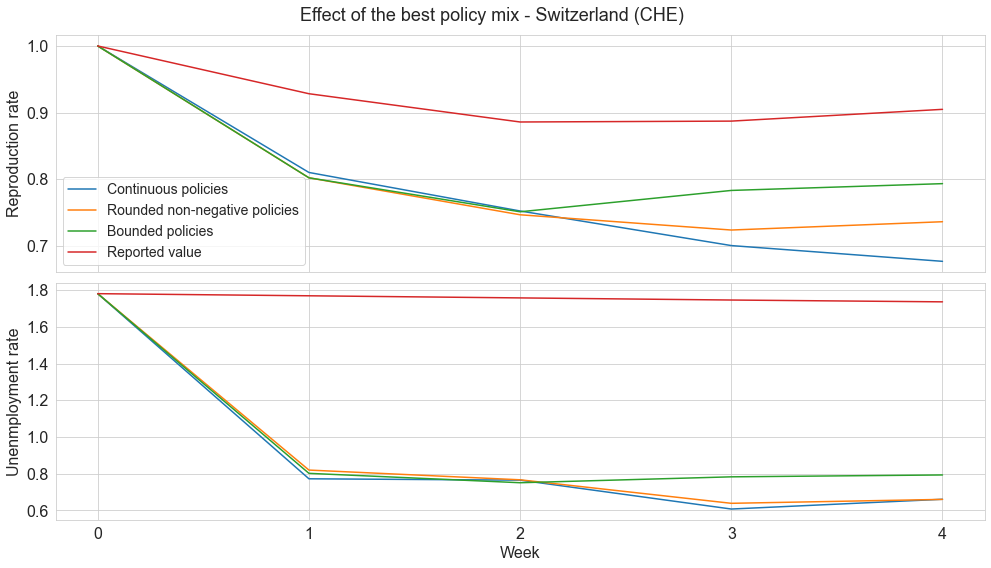

In [48]:
def visualize_effect(states):
    x = [0]

    y_1 = [reproduction_rate_true[0]]
    y_2 = [reproduction_rate_true[0]]
    y_3 = [reproduction_rate_true[0]]
    
    y_1_unemp = [economic_true[0]]
    y_2_unemp = [economic_true[0]]
    y_3_unemp = [economic_true[0]]
    
    for i, week in enumerate(states):
        week_rounded = week.round()
        week_rounded = np.where(week_rounded <= 0, 0, week_rounded)
        x.append(i+1)

        y_1.append(predict_from_state(week)[0])
        y_2.append(predict_from_state(week_rounded)[0])

        y_1_unemp.append(predict_from_state(week)[1])
        y_2_unemp.append(predict_from_state(week_rounded)[1])
        
        for i in range(len(week_rounded)):
            if week_rounded[i] > variation_policy_level[i%len(variation_policy_level)]:
                week_rounded[i] = variation_policy_level[i%len(variation_policy_level)]
    
        y_3.append(predict_from_state(week_rounded)[0])
        y_3_unemp.append(predict_from_state(week_rounded)[0])
        
    sns.set_style("whitegrid")
    
    fig, axis = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
    
    fig.suptitle(f"Effect of the best policy mix - Switzerland ({TARGET_COUNTRY})", fontsize=18)

    axis[0].set_ylabel('Reproduction rate', fontsize=16)
    axis[0].plot(x, y_1, label="Continuous policies")
    axis[0].plot(x, y_2, label="Rounded non-negative policies")
    axis[0].plot(x, y_3, label="Bounded policies")
    axis[0].plot(x, reproduction_rate_true, label="Reported value")
    axis[0].legend(fontsize=14);
    axis[0].tick_params(labelsize=16)
  #  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    axis[1].set_ylabel('Unenmployment rate', fontsize=16)  # we already handled the x-label with ax1
    axis[1].plot(x, y_1_unemp, label="Continuous policies")
    axis[1].plot(x, y_2_unemp, label="Rounded non-negative policies")
    axis[1].plot(x, y_3_unemp, label="Bounded policies")
    axis[1].plot(x, economic_true, label="Reported value")
    axis[1].set_xlabel('Week', fontsize=16)
    axis[1].tick_params(labelsize=16)
    
    axis[0].set_xticks([0,1,2,3,4])
    axis[1].set_xticks([0,1,2,3,4])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.savefig('RL_CHE.pdf', bbox_inches='tight')
    plt.show()
   
        
visualize_effect(best_states)

### Comparison with a random agent

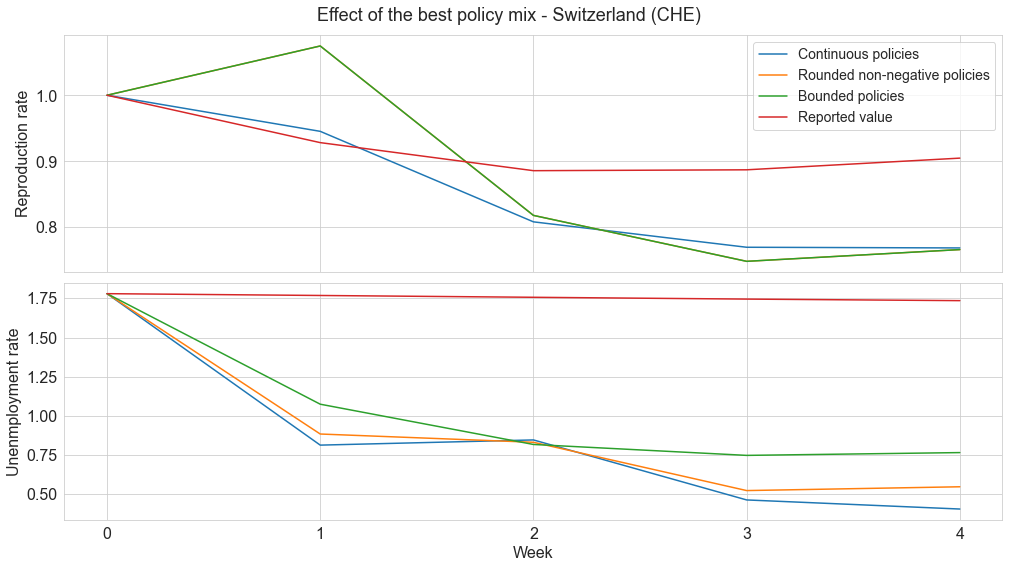

In [49]:
visualize_effect(best_states_random)

### Step 4: visualizing the policies

In [50]:
next_month_policies = best_states[-1].round()
next_month_policies = np.where(next_month_policies<=0, 0, next_month_policies)
next_month_policies

array([1., 1., 2., 3., 3., 5., 1., 2., 1., 1., 2., 0., 1., 2., 4., 3., 6.,
       2., 1., 1., 1., 1., 0., 2., 3., 5., 4., 7., 3., 0., 2., 2., 2., 0.,
       1., 4., 6., 5., 8., 4., 0., 1., 2., 3.])

In [51]:
for i in range(len(next_month_policies)):
    if next_month_policies[i] > variation_policy_level[i%len(variation_policy_level)]:
        next_month_policies[i] = variation_policy_level[i%len(variation_policy_level)]

In [52]:
next_month_policies = next_month_policies.reshape((WINDOW_SIZE // CHANGE_EVERY, len(variation_policy_level))).T

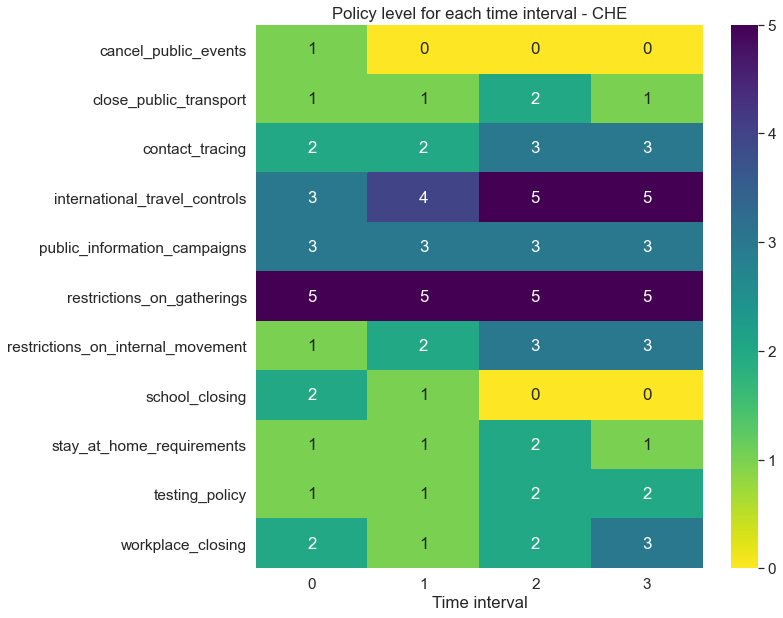

In [53]:
plt.figure(figsize=(10, 10))
sns.set(font_scale = 1.4)
plt.title(f"Policy level for each time interval - {TARGET_COUNTRY}")
sns.heatmap(next_month_policies, annot=True, yticklabels=variable_names, cmap='viridis_r');
plt.xlabel("Time interval");

In [54]:
next_month_policies_del = np.delete(next_month_policies, [2, 9, 10], 0)

names = np.delete(variable_names, [2, 9, 10], 0)
names = [n.replace("_", " ").capitalize() for n in names]

In [55]:
df = pd.read_csv("./output/contour-export-21-06-2021.csv")

df = df[(df['date'] == '2021-04-12') | (df['date'] == '2021-04-19') | (df['date'] == '2021-04-26') | (df['date'] == '2021-05-03')]
df = df.iloc[:, 3:]
df = df.reindex(sorted(df.columns), axis=1)

next_month_policies_true = df.values.T
variable_names = df.columns.str.replace('_', ' ').str.capitalize().values

In [56]:
next_month_policies_true

array([[2, 1, 1, 1],
       [0, 0, 0, 0],
       [3, 3, 3, 3],
       [2, 2, 2, 2],
       [4, 4, 4, 4],
       [0, 0, 0, 0],
       [2, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

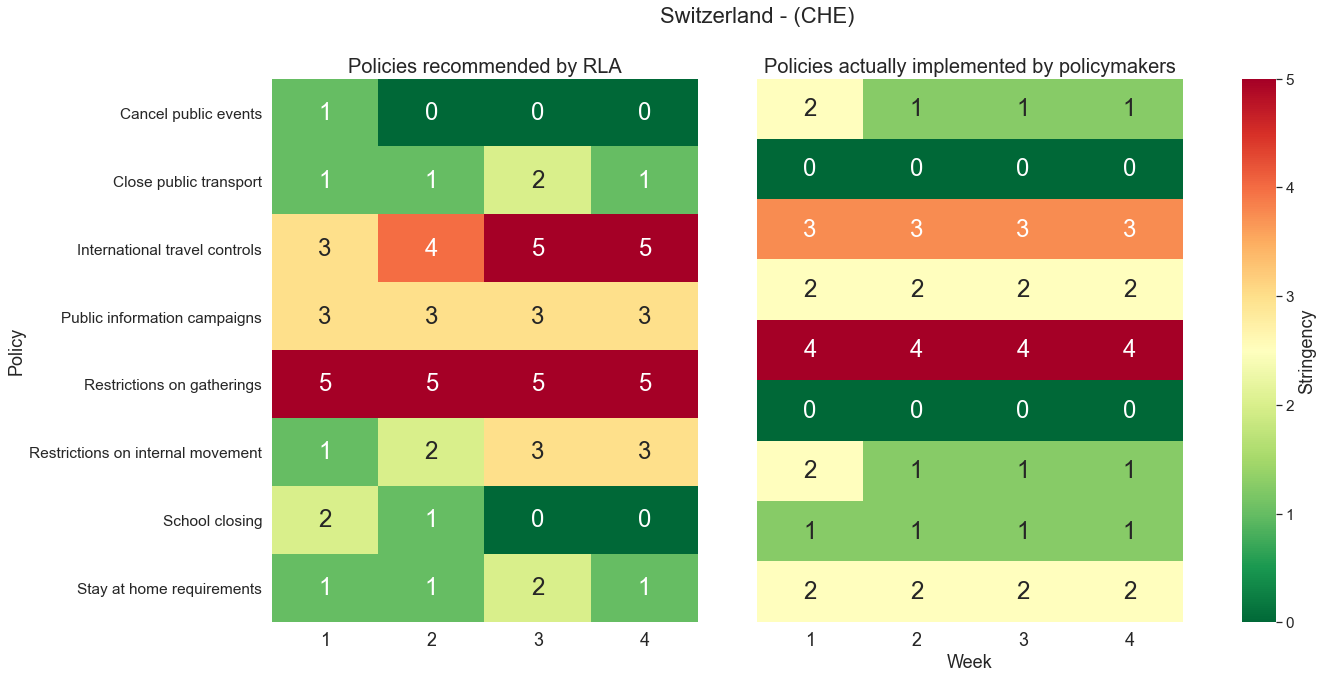

In [57]:
fig, axis = plt.subplots(1, 3, figsize=(18, 10), gridspec_kw={'width_ratios':[1,1,0.08]})

sns.set(font_scale = 2)

sns.heatmap(next_month_policies_del, cmap='RdYlGn_r', annot=True, xticklabels=[1,2,3,4], yticklabels=names, ax = axis[0], cbar_kws={"label": "Stringency", "ticks": [0, 1, 2, 3, 4, 5]}, cbar_ax=axis[2])
sns.heatmap(next_month_policies_true, cmap='RdYlGn_r', annot=True, xticklabels=[1,2,3,4], ax = axis[1], cbar=False)

fig.suptitle(f"Switzerland - ({TARGET_COUNTRY})", fontsize=22)
axis[0].set_title(f"Policies recommended by RLA", fontsize=20)
axis[1].set_title(f"Policies actually implemented by policymakers", fontsize=20)

axis[1].set_ylabel("");
axis[0].set_ylabel("Policy", fontsize=18);
axis[0].set_xlabel("");
axis[1].set_xlabel("Week", fontsize=18);
axis[2].set_ylabel("Stringency", fontsize=18);

axis[1].set_yticks([])

axis[0].xaxis.set_tick_params(labelsize=18)
axis[1].xaxis.set_tick_params(labelsize=18)

fig.savefig('heatmap_RL.pdf', bbox_inches='tight')




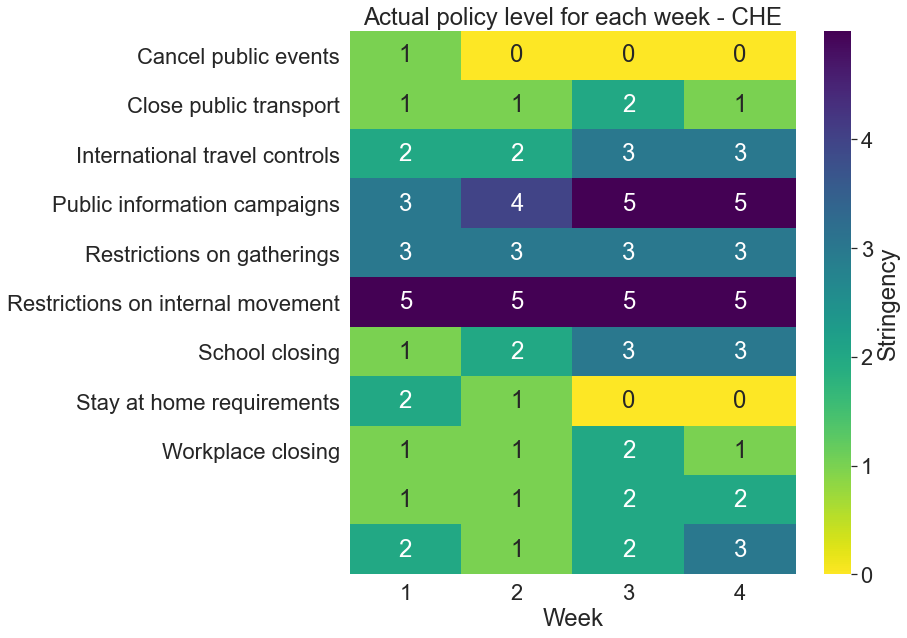

In [58]:


plt.figure(figsize=(10, 10))
sns.set(font_scale = 2)
plt.title(f"Actual policy level for each week - CHE")
sns.heatmap(next_month_policies, annot=True, yticklabels=variable_names, cmap='viridis_r', xticklabels=[1,2,3,4], cbar_kws={"label": "Stringency", "ticks": [0, 1, 2, 3, 4]});
plt.xlabel("Week");
plt.savefig('actual_policy_level.pdf', bbox_inches='tight')